In [14]:
import pandas as pd
import numpy as np
import nltk
import ast
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Load csv file
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,Product Name,product,title,format,stars,comments,helpful
0,1,galaxyon7Size: 32GB,galaxyon7,Beautiful premium metallic design,Size: 32GB,5,I have used this phone almost a month. So I wa...,60.0
1,2,galaxyon7Size: 64GB,galaxyon7,Budget phone But Could Have Been Better!,Size: 64GB,4,Hello Samsung Lovers!This phone looks beautifu...,107.0
2,3,galaxyon7Size: 32GB,galaxyon7,Another Failed Attempt by Samsung!,Size: 32GB,1,"Well, when I started reviewing the Galaxy On7 ...",21.0
3,4,galaxyon7Size: 64GB,galaxyon7,My mobile headset is not recived i was return ...,Size: 64GB,1,My mobile headset is not recived i was retur...,3.0
4,5,galaxyon7Size: 32GB,galaxyon7,Good Mid Budget Smartphone,Size: 32GB,5,A Good Mid budget phone..1. Display: With a Sa...,8.0


In [16]:

print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['product']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['stars']==3]["comments"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['stars']>3]["comments"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['stars']<3]["comments"].count()/len(df)*100))

Summary statistics of numerical features : 
         Unnamed: 0        stars      helpful
count  3600.000000  3600.000000  2315.000000
mean   1800.500000     3.927222     4.805184
std    1039.374812     1.432459    15.192188
min       1.000000     1.000000     1.000000
25%     900.750000     3.000000     1.000000
50%    1800.500000     5.000000     2.000000
75%    2700.250000     5.000000     3.000000
max    3600.000000     5.000000   351.000000

Total number of reviews:  3600

Total number of brands:  12

Total number of unique products:  15

Percentage of reviews with neutral sentiment : 7.94%

Percentage of reviews with positive sentiment : 72.33%

Percentage of reviews with negative sentiment : 19.03%


Text(0, 0.5, 'Count')

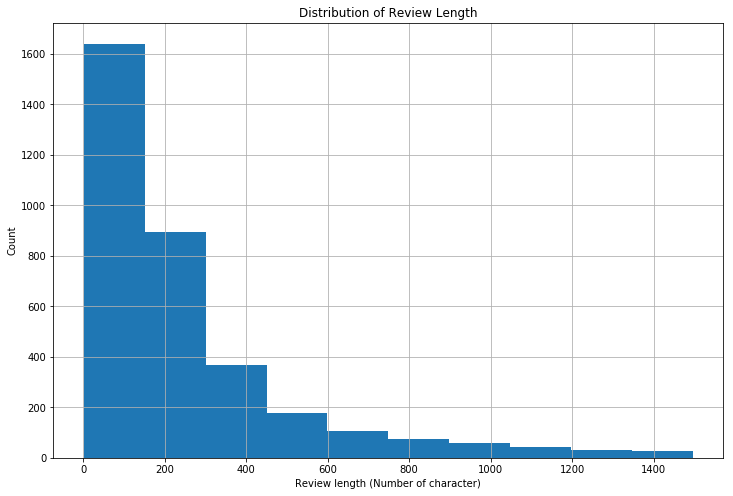

In [17]:
# Plot distribution of review length
review_length = df["comments"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [18]:

df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['stars'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['stars'] > 3, 1, 0)
df.head()

,Unnamed: 0,Product Name,product,title,format,stars,comments,helpful,Sentiment
1303,1304,lenovok8noteSize: 4 GB,lenovok8note,some these photos are taken in complete dark ...,Size: 4 GB,5,i don't why people are saying the cameras of p...,31.0,1
1311,1312,lenovok8noteSize: 4 GB,lenovok8note,KillerNote Should have Dual 4G Standby.,Size: 4 GB,4,Good Mobile.Dual 4G Standby is not available.H...,1.0,1
581,582,iphoneseColour: Gold,iphonese,Four Stars,Colour: Gold,4,its working awesome...,2.0,1
635,636,redmenoteColour: Grey,redmenote,Awsome........,Colour: Grey,5,Superb mobile....go for it without any hesitat...,1.0,1
196,197,galaxyon7Size: 64GB,galaxyon7,Battery back up and camera quality is amazing.,Size: 64GB,5,Superb stylish and sleek phone. First lowest p...,5.0,1


In [19]:
from sklearn.model_selection import train_test_split
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['comments'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 87 training examples and 10 validation examples. 

Show a review in the training set : 
 Writing this a day after receiving the phone. I was afraid after seeing all the negative reviews about tampered boxes, faulty or recycled accessories, etc. But, I received a factory packed iPhone SE - no tampering! It was Amazon Fulfilled and I always only order such products. Everything inside the box was brand new and the phone works great. I was exchanging it for my iPhone 5 and I am very satisfied :-)I have bought from Amazon so many times - both in US and in India - in the past 11 years. I only choose products that ship from the Amazon Warehouse. I never had to return anything ever so far!


In [8]:
from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

In [12]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    if remove_stopwords: # remove stopword
        stops = nltk.corpus.stopwords.words("english")
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [13]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 writing this a day after receiving the phone i was afraid after seeing all the negative reviews about tampered boxes faulty or recycled accessories etc but i received a factory packed iphone se no tampering it was amazon fulfilled and i always only order such products everything inside the box was brand new and the phone works great i was exchanging it for my iphone and i am very satisfied i have bought from amazon so many times both in us and in india in the past years i only choose products that ship from the amazon warehouse i never had to return anything ever so far


In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

In [57]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

86 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['writing', 'this', 'a', 'day', 'after', 'receiving', 'the', 'phone', 'i', 'was', 'afraid', 'after', 'seeing', 'all', 'the', 'negative', 'reviews', 'about', 'tampered', 'boxes', 'faulty', 'or', 'recycled', 'accessories', 'etc', 'but', 'i', 'received', 'a', 'factory', 'packed', 'iphone', 'se', 'no', 'tampering', 'it', 'was', 'amazon', 'fulfilled', 'and', 'i', 'always', 'only', 'order', 'such', 'products', 'everything', 'inside', 'the', 'box', 'was', 'brand', 'new', 'and', 'the', 'phone', 'works', 'great', 'i', 'was', 'exchanging', 'it', 'for', 'my', 'iphone', 'and', 'i', 'am', 'very', 'satisfied', 'i', 'have', 'bought', 'from', 'amazon', 'so', 'many', 'times', 'both', 'in', 'us', 'and', 'in', 'india', 'in', 'the', 'past', 'years', 'i', 'only', 'choose', 'products', 'that', 'ship', 'from', 'the', 'amazon', 'warehouse', 'i', 'never', 'had', 'to', 'return', 'anything', 'ever', 'so', 'far']


In [58]:
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 133 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'is', 'and', 'to', 'i', 'it', 'a', 'phone', 'with', 'of']


In [59]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [60]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


# debugging
# print("Checkinf for NaN and Inf")
# print("np.inf=", np.where(np.isnan(trainVector)))
# print("is.inf=", np.where(np.isinf(trainVector)))
# print("np.max=", np.max(abs(trainVector)))

Training set : 87 feature vectors with 300 dimensions
Validation set : 10 feature vectors with 300 dimensions


C:\Users\Satra\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [61]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.6000

AUC score : 0.5000

Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.60      1.00      0.75         6

   micro avg       0.60      0.60      0.60        10
   macro avg       0.30      0.50      0.37        10
weighted avg       0.36      0.60      0.45        10


Confusion Matrix : 
 [[0 4]
 [0 6]]


C:\Users\Satra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Satra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Satra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
